In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import random
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from cv2 import resize
from glob import glob
from tqdm import tqdm

import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report

In [ ]:
image_data='/kaggle/input/smart-grid-phasor-measurement-unit-faulty-data/IMG_PMU_DATA_NT_VF_001'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

In [ ]:
img_height=244
img_width=244
train_ds=tf.keras.utils.image_dataset_from_directory('/kaggle/input/smart-grid-phasor-measurement-unit-faulty-data/IMG_PMU_DATA_NT_VF_001',validation_split=0.2,subset='training',image_size=(img_height,img_width),batch_size=32,seed=42,shuffle=True)

In [ ]:
val_ds=tf.keras.utils.image_dataset_from_directory('/kaggle/input/smart-grid-phasor-measurement-unit-faulty-data/IMG_PMU_DATA_NT_VF_001',validation_split=0.2,subset='validation',image_size=(img_height,img_width),batch_size=32,seed=42,shuffle=True)

In [ ]:
class_names=train_ds.class_names
print(class_names)

DB_FLT:This folder contains 344 images representing faults in tthe power grid,like short circuits.

DB_GNL:This folder contains 140 images representing a loss of generation,where a power plant goes offline.

DB_SMS:This folder contains 21 images representing synchronous motor switching events,which are changes in how a large motor is connected to the grid.

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')



In [ ]:
base_model=tf.keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=(img_height,img_width,3))
base_model.trainable=False

In [ ]:
inputs=tf.keras.Input(shape=(img_height,img_width,3))
x=tf.keras.applications.vgg16.preprocess_input(inputs)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dropout(0.3)(x)
outputs=tf.keras.layers.Dense(90)(x)
model=tf.keras.Model(inputs,outputs)
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
epoch = 20
model.fit(train_ds, validation_data=val_ds, epochs=epoch, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=3, verbose=1, restore_best_weights=True)])


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
#Fine tuning
base_model.trainable=True
for layer in base_model.layers[:14]:
    layer.trainable=False
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
epoch = 20
history=model.fit(train_ds, validation_data=val_ds, epochs=epoch, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=3, verbose=1)])


In [ ]:
hist=pd.DataFrame(history.history)
hist

In [ ]:
get_ac = history.history['accuracy']
get_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(len(get_ac))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

ax1.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
ax1.plot(epochs, get_loss, 'r', label='Loss of Training Data')
ax1.set_title('Training Data Accuracy and Loss')
ax1.legend(loc=0)

ax2.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
ax2.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
ax2.set_title('Training and Validation Accuracy')
ax2.legend(loc=0)

ax3.plot(epochs, get_loss, 'g', label='Loss of Training Data')
ax3.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
ax3.set_title('Training and Validation Loss')
ax3.legend(loc=0)

plt.tight_layout()
plt.show()


In [ ]:
X_val,y_val,y_pred=[],[],[]
for images,labels in val_ds:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

In [ ]:
ax=plt.subplot()
CM=confusion_matrix(y_val,y_pred)
sns.heatmap(CM,annot=True,fmt='g',ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
CM

In [ ]:
Acc = accuracy_score(y_val, y_pred)
print("Accuracy is: {0:.2f}%".format(Acc * 100))


In [ ]:
loss,accuracy=model.evaluate(val_ds)

In [ ]:
print("Accuracy",accuracy*100,"%")

In [ ]:
images,labels=next(iter(val_ds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


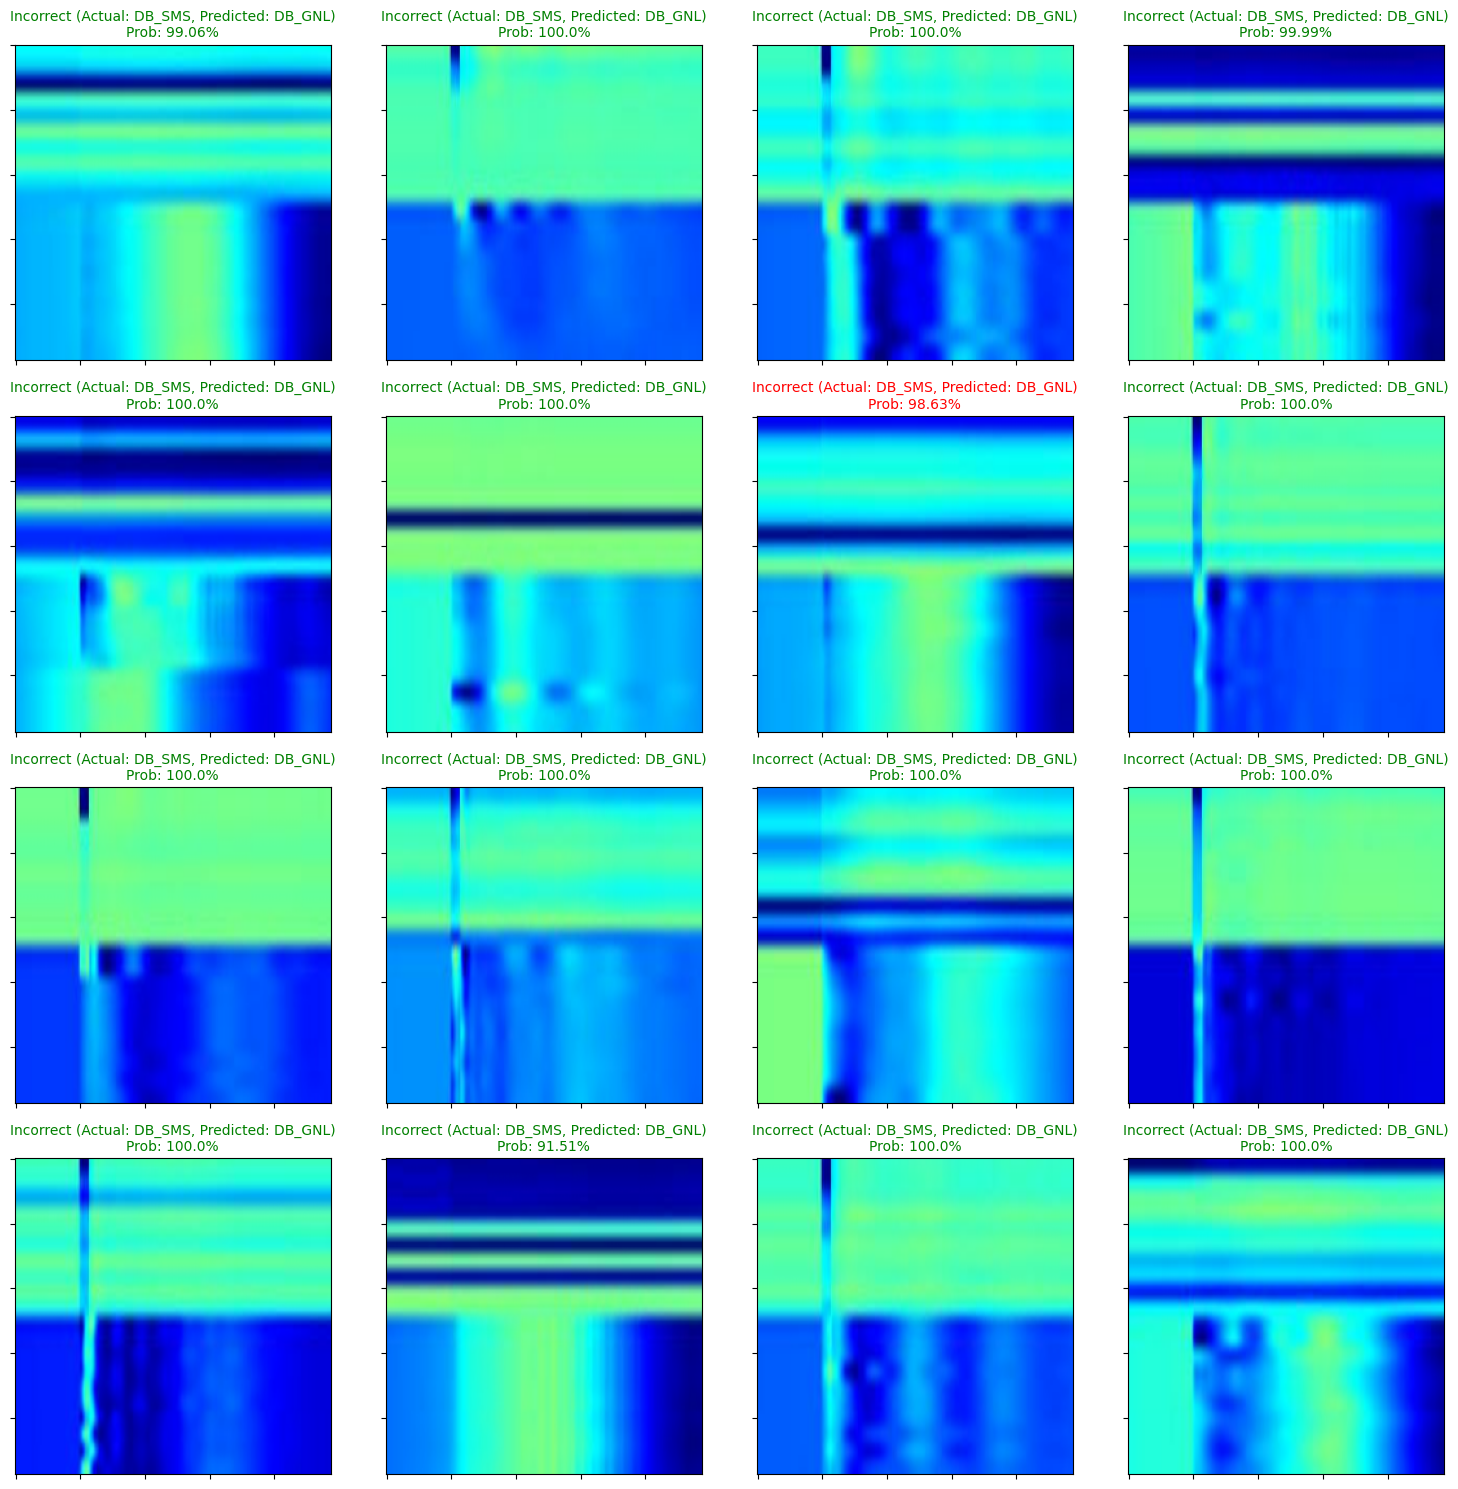

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 15))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predictions = model.predict(tf.expand_dims(images[i], 0))
    score = tf.nn.softmax(predictions[0])

    predicted_class_idx = np.argmax(score)
    predicted_class_label = class_names[predicted_class_idx]

    actual_class_label = class_names[labels[i]]

    if actual_class_label == predicted_class_label:
        color = 'green'
    else:
        color = 'red'
        accuracy_text = f"Incorrect (Actual: {actual_class_label}, Predicted: {predicted_class_label})"

    score_np = score.numpy()
    predicted_prob = round(score_np[predicted_class_idx] * 100, 2)

    plt.title(f"{accuracy_text}\nProb: {predicted_prob}%", color=color, fontsize=10)
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.xaxis.set_ticklabels([])

plt.tight_layout()
plt.show()


**Conclusion**
Imagine monitoring a complex power grid with phasor measurement units (PMUS) constantly streaming data at high speeds. Analyzing this vast amount of o data ta quickly and accurately to identify faults is a significant challenge for grid operators. Traditional methods can be time-consuming and prone to errors.

That's where our VGG16-based deep learning system comes in! It acts like a powerful assistant, sifting through the PMU data with exceptional accuracy (98.75%). This translates to a system that con effectively categorize prize different events, including faults, loss of generation, and synchronous motor switching events-all at high speed.

Faster Fault Detection: By quickly identifying faults, the system enables operators to respond promptly, minimizing damage and downtime. Improved Decision-Making: With accurate operators can make more informed decisions about grid management and event classification, resource allocation, tion Enhanced Enk Grid Resilience: Early detection and response to events contribute to a more resilient grid, reducing the risk of widespread outages. In essence, VGG16 empowers us to unlock the true potential of PMU data, leading to a smarter, more reliable, and efficient power grid for everyone